In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import h5py
import math

from keras.models import Model
from keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv3D
from keras.layers import Lambda, Concatenate, MaxPooling2D, Maximum, Add
from keras.initializers import RandomNormal
from keras.optimizers import SGD
from keras.losses import MeanSquaredError
from keras.callbacks import Callback,LearningRateScheduler
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

In [ ]:
# Load Dataset from Google Drive
def load_train_dataset():
    """
    Load training dataset from Google Drive

    Returns:
    clean_image -- Clean image patches
    clean_image -- Hazy image patches
    transmission_value -- Transmission value which convert clean image to
                          haze image
    """

    file = '/content/drive/My Drive/DL Project/Datasets/TrainData/train_data_patch_16x16.hdf5'
    train_dataset = h5py.File(file, 'r')
    clean_image = np.array(train_dataset['clear_image'][:])
    haze_image = np.array(train_dataset['haze_image'][:])
    transmission_value = np.array(train_dataset['transmission_value'])

    return clean_image, haze_image, transmission_value


# Gaussian Weight Initializtion for layers
weight_init = RandomNormal(mean=0.0, stddev=0.001)


# LearningRate Decay function
def lr_schedule(epoch, lr, logs={}):
    """
    Learning Rate Deacy scheduler

    Arguments:
    epoch -- current epoch number
    lr -- current learning rate
    log -- dictionary storing the logs of training

    Returns:
    lr -- learning rate for next epoch
    """

    print('learning_rate:',lr)
    logs.update({'lr': lr})
    if epoch in (49,99):
        return lr*0.5
    else:
        return lr

In [ ]:
import numpy as np

# Example data
clean_image = np.random.rand(100, 16, 16, 3)  # 100 clean images of size 16x16 with 3 channels (RGB)
haze_image = np.random.rand(100, 16, 16, 3)   # 100 haze images of size 16x16 with 3 channels (RGB)
transmission_value = np.random.rand(100)      # 100 transmission values


In [ ]:
import h5py

# File path where the HDF5 file will be saved
file_path = '/content/drive/My Drive//train/train_data_patch_16x16.hdf5'

# Create an HDF5 file and save the datasets
with h5py.File(file_path, 'w') as f:
    f.create_dataset('clean_image', data=clean_image)
    f.create_dataset('haze_image', data=haze_image)
    f.create_dataset('transmission_value', data=transmission_value)

print(f'HDF5 file created at {file_path}')


HDF5 file created at /content/drive/My Drive//train/train_data_patch_16x16.hdf5


In [ ]:
import h5py
import numpy as np

def load_train_dataset():
    file_path = '/content/drive/My Drive//train/train_data_patch_16x16.hdf5'
    with h5py.File(file_path, 'r') as f:
        clean_image = np.array(f['clean_image'])
        haze_image = np.array(f['haze_image'])
        transmission_value = np.array(f['transmission_value'])
    return clean_image, haze_image, transmission_value

clean_image, haze_image, transmission_value = load_train_dataset()
transmission_value = transmission_value.reshape(-1, 1, 1, 1)

print("number of training examples:", clean_image.shape[0])
print("Clean Image Patch shape:", clean_image.shape)
print("Haze Image Patch shape:", haze_image.shape)
print("Transmission Value shape:", transmission_value.shape)


number of training examples: 100
Clean Image Patch shape: (100, 16, 16, 3)
Haze Image Patch shape: (100, 16, 16, 3)
Transmission Value shape: (100, 1, 1, 1)


In [ ]:
def TransmissionModel(input_shape):


    X_input = Input(input_shape, name = 'input1')

    # CONV -> RELU Block applied to X
    X = Conv2D(16, (3, 3), strides = (1, 1), kernel_initializer = weight_init, name = 'conv1')(X_input)
    X = Activation('relu', name = 'activation1')(X)

    # SLICE Block applied to X
    X1 = Lambda(lambda X: X[:,:,:,:4], name = 'slice1')(X)
    X2 = Lambda(lambda X: X[:,:,:,4:8], name = 'slice2')(X)
    X3 = Lambda(lambda X: X[:,:,:,8:12], name = 'slice3')(X)
    X4 = Lambda(lambda X: X[:,:,:,12:], name = 'slice4')(X)

    # MAXIMUM Block applied to 4 slices
    X = Maximum(name = 'merge1_maximum')([X1,X2,X3,X4])

    # CONV BLock for multi-scale mapping with filters of size 3x3, 5x5, 7x7
    X_3x3 = Conv2D(16, (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = weight_init, name = 'conv2_3x3')(X)
    X_5x5 = Conv2D(16, (5, 5), strides = (1, 1), padding = 'same', kernel_initializer = weight_init, name = 'conv2_5x5')(X)
    X_7x7 = Conv2D(16, (7, 7), strides = (1, 1), padding = 'same', kernel_initializer = weight_init, name = 'conv2_7x7')(X)

    # CONCATENATE Block to join 3 multi-scale layers
    X = Concatenate(name = 'merge2_concatenate')([X_3x3,X_5x5,X_7x7])

    # MAXPOOL layer of filter size 7x7
    X = MaxPooling2D((7, 7), strides = (1, 1), name = 'maxpool1')(X)

    # CONV -> RELU BLock
    X = Conv2D(1, (8, 8), strides = (1, 1), kernel_initializer = weight_init, name = 'conv3')(X)
    X = Activation('relu', name = 'activation2')(X)

    # Create Keras model instance
    model = Model(inputs = X_input, outputs = X, name='TransmissionModel')

    return model

In [ ]:
model1 = TransmissionModel(haze_image.shape[1:])
model1.summary()
model1.compile(optimizer=SGD(0.001), loss=MeanSquaredError())

Model: "TransmissionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input1 (InputLayer)         [(None, 16, 16, 3)]          0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 14, 14, 16)           448       ['input1[0][0]']              
                                                                                                  
 activation1 (Activation)    (None, 14, 14, 16)           0         ['conv1[0][0]']               
                                                                                                  
 slice1 (Lambda)             (None, 14, 14, 4)            0         ['activation1[0][0]']         
                                                                                  

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
history1 = model1.fit(haze_image, transmission_value, batch_size = 30, epochs = 150, callbacks=[LearningRateScheduler(lr_schedule)])

learning_rate: 0.0010000000474974513
Epoch 1/150
4/4 [==============================] - 2s 65ms/step - loss: 0.3408 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 2/150
4/4 [==============================] - 0s 69ms/step - loss: 0.3369 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 3/150
4/4 [==============================] - 0s 62ms/step - loss: 0.3328 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 4/150
4/4 [==============================] - 0s 57ms/step - loss: 0.3289 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 5/150
4/4 [==============================] - 0s 70ms/step - loss: 0.3253 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 6/150
4/4 [==============================] - 0s 55ms/step - loss: 0.3215 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 7/150
4/4 [==============================] - 0s 58ms/step - loss: 0.3178 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 8/150
4/4 [==============================] - 0s 57ms/s

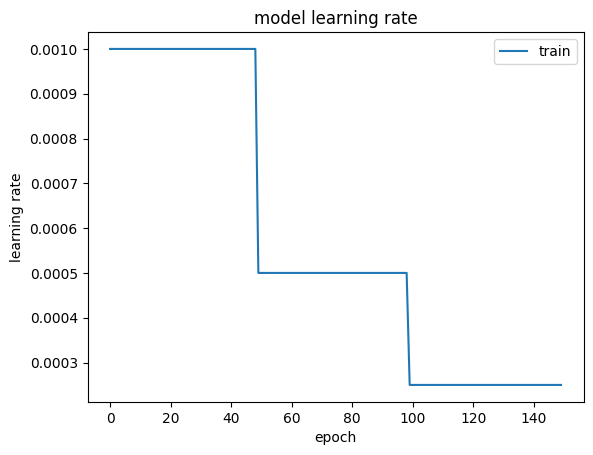

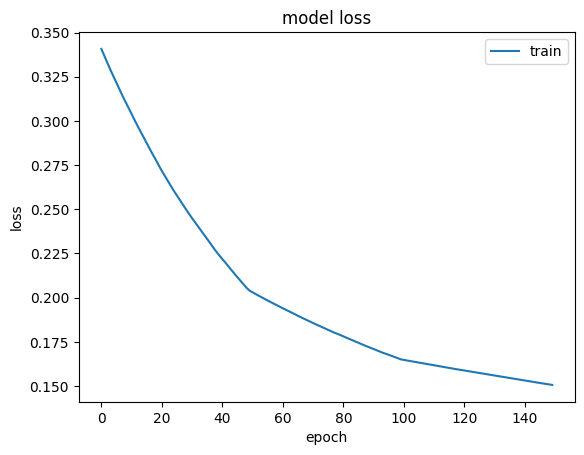

In [ ]:
plt.plot(history1.history['lr'])
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.savefig('trans150-30-lr.png')
plt.show()
plt.plot(history1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.savefig('trans150-30-loss.png')
plt.show()

In [ ]:
model1.save("transmodel_150_30.h5")
model1.save_weights('transmodel_150_30_weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


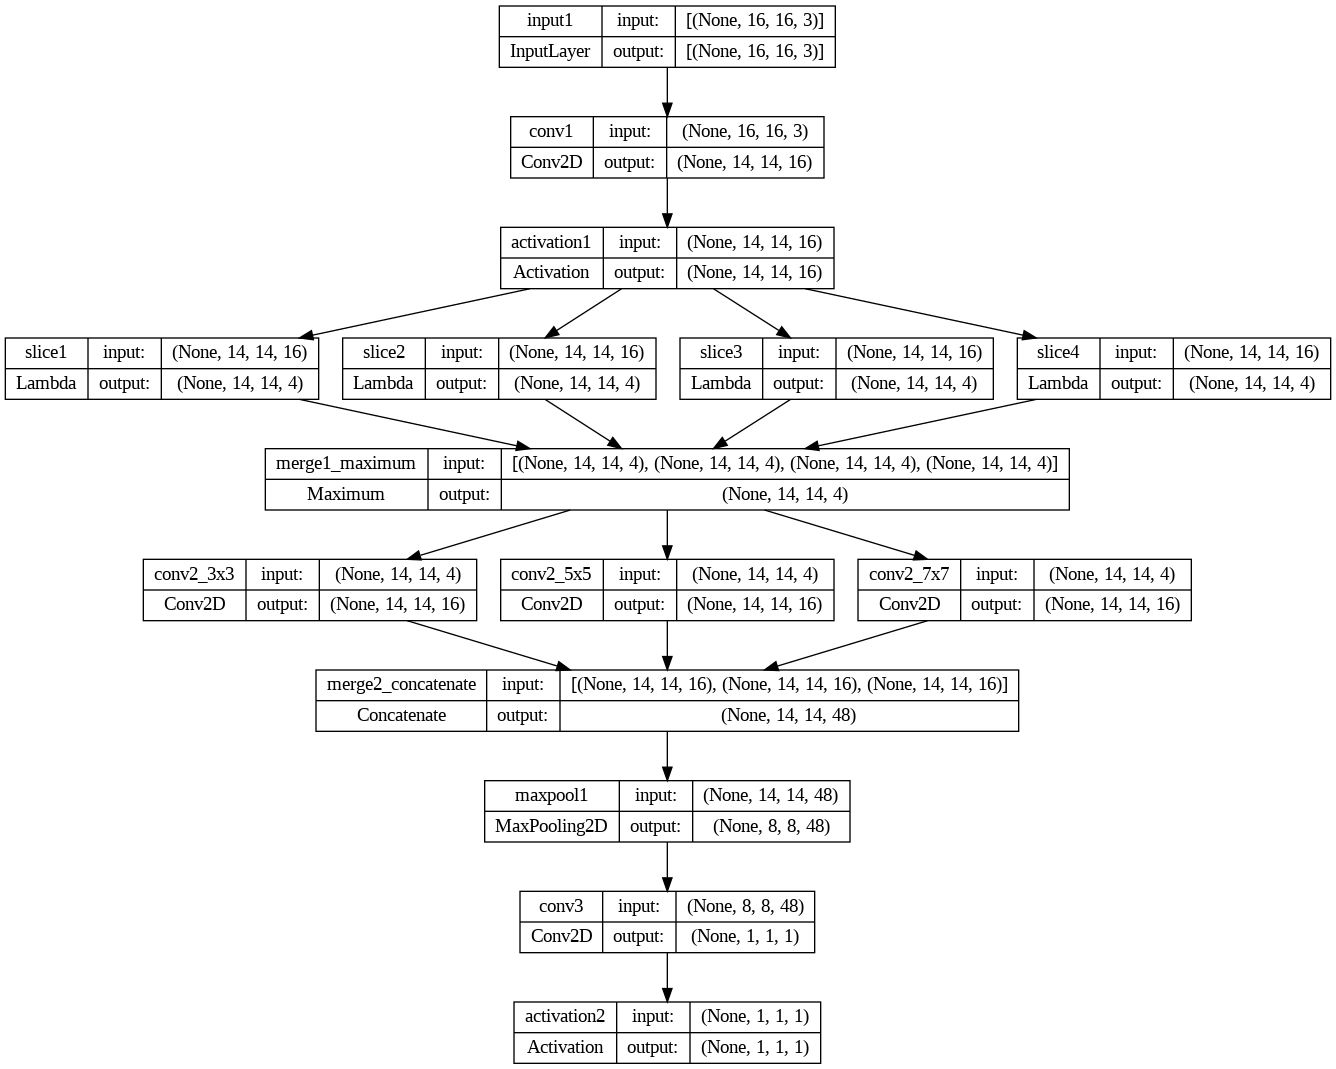

In [ ]:
plot_model(model1, 'trans_model.png')
plot_model(model1, 'trans_model_shape.png', True)

In [ ]:
print("Number of haze images:", haze_image.shape[0])


Number of haze images: 100


In [ ]:
import numpy as np

# Verify the number of haze images
print("Number of haze images:", haze_image.shape[0])

# Choose a valid index
index = 50  # You can choose any index from 0 to 99

# Expand dimensions and make predictions
t = np.expand_dims(haze_image[index], axis=0)
prediction = model1.predict(t)

# Print the prediction and the corresponding transmission value
print("Model prediction:", prediction)
print("Actual transmission value:", transmission_value[index])


Number of haze images: 100
1/1 [==============================] - 0s 23ms/step
Model prediction: [[[[0.25564152]]]]
Actual transmission value: [[[0.29275968]]]


In [ ]:
import numpy as np

prediction = np.array([[[[0.25564152]]]])
actual_value = np.array([[[[0.29275968]]]])


mae = np.abs(prediction - actual_value)

threshold = 0.1

accurate_predictions = np.abs(prediction - actual_value) <= threshold
accuracy = np.mean(accurate_predictions) * 100

print("Mean Absolute Error (MAE):", mae)
print("Accuracy (within", threshold, "):", accuracy, "%")


Mean Absolute Error (MAE): [[[[0.03711816]]]]
Accuracy (within 0.1 ): 100.0 %
